# ID5059 P2 - Credit Card Fraud Detection
180016546, _, _, _, _

#### Plan:
1. Setup
2. Explore data
3. Imputing
4. Balancing
5. Present Models
    1. Decision Tree Classifier
    2. Logistic Regression
    3. Random Forest
    4. Stochastic Gradient Descent
6. Evaluation

### 1. Setup
Import required libraries.

In [1]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn seaborn | grep -v 'already satisfied'

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.impute
import datetime
import seaborn as sb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.model_selection import GridSearchCV
%matplotlib inline 

SEED = 618

Defaulting to user installation because normal site-packages is not writeable


Read in datasets.

In [3]:
# read in data
train = pd.read_csv("../train.csv")
test = pd.read_csv("../test.csv")

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)

train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


Split `train` data into `X` and `y`.

In [4]:
# set id as index
train = train.set_index('id')
test = test.set_index('id')

# split train set into X_train, y_train
y_train = train['Class']
X_train = train.drop('Class', axis = 1)

---

### 2. Explore data
Check dataset completeness

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219129 entries, 0 to 219128
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    219129 non-null  float64
 1   V1      219129 non-null  float64
 2   V2      219129 non-null  float64
 3   V3      219129 non-null  float64
 4   V4      219129 non-null  float64
 5   V5      219129 non-null  float64
 6   V6      219129 non-null  float64
 7   V7      219129 non-null  float64
 8   V8      219129 non-null  float64
 9   V9      219129 non-null  float64
 10  V10     219129 non-null  float64
 11  V11     219129 non-null  float64
 12  V12     219129 non-null  float64
 13  V13     219129 non-null  float64
 14  V14     219129 non-null  float64
 15  V15     219129 non-null  float64
 16  V16     219129 non-null  float64
 17  V17     219129 non-null  float64
 18  V18     219129 non-null  float64
 19  V19     219129 non-null  float64
 20  V20     219129 non-null  float64
 21  V21     21

Dataset is complete! All floats except `Class` which is `int`:

In [22]:
train['Class'].unique()

array([0, 1])

`Class` is binary: 0 = no fraud, 1 = fraud. Lets investigate fraud rate in `train`.

In [5]:
# lets just check how much of our train set is fraudulent
fraud = train['Class'].sum()
fraud_percent = fraud/len(train['Class']) * 100

print('fraud:', fraud, '\ntotal entries:', len(train['Class']), '\nfraud rate', round(fraud_percent, 2), '%')

fraud: 469 
total entries: 219129 
fraud rate 0.21 %


Visualise columm value spread.

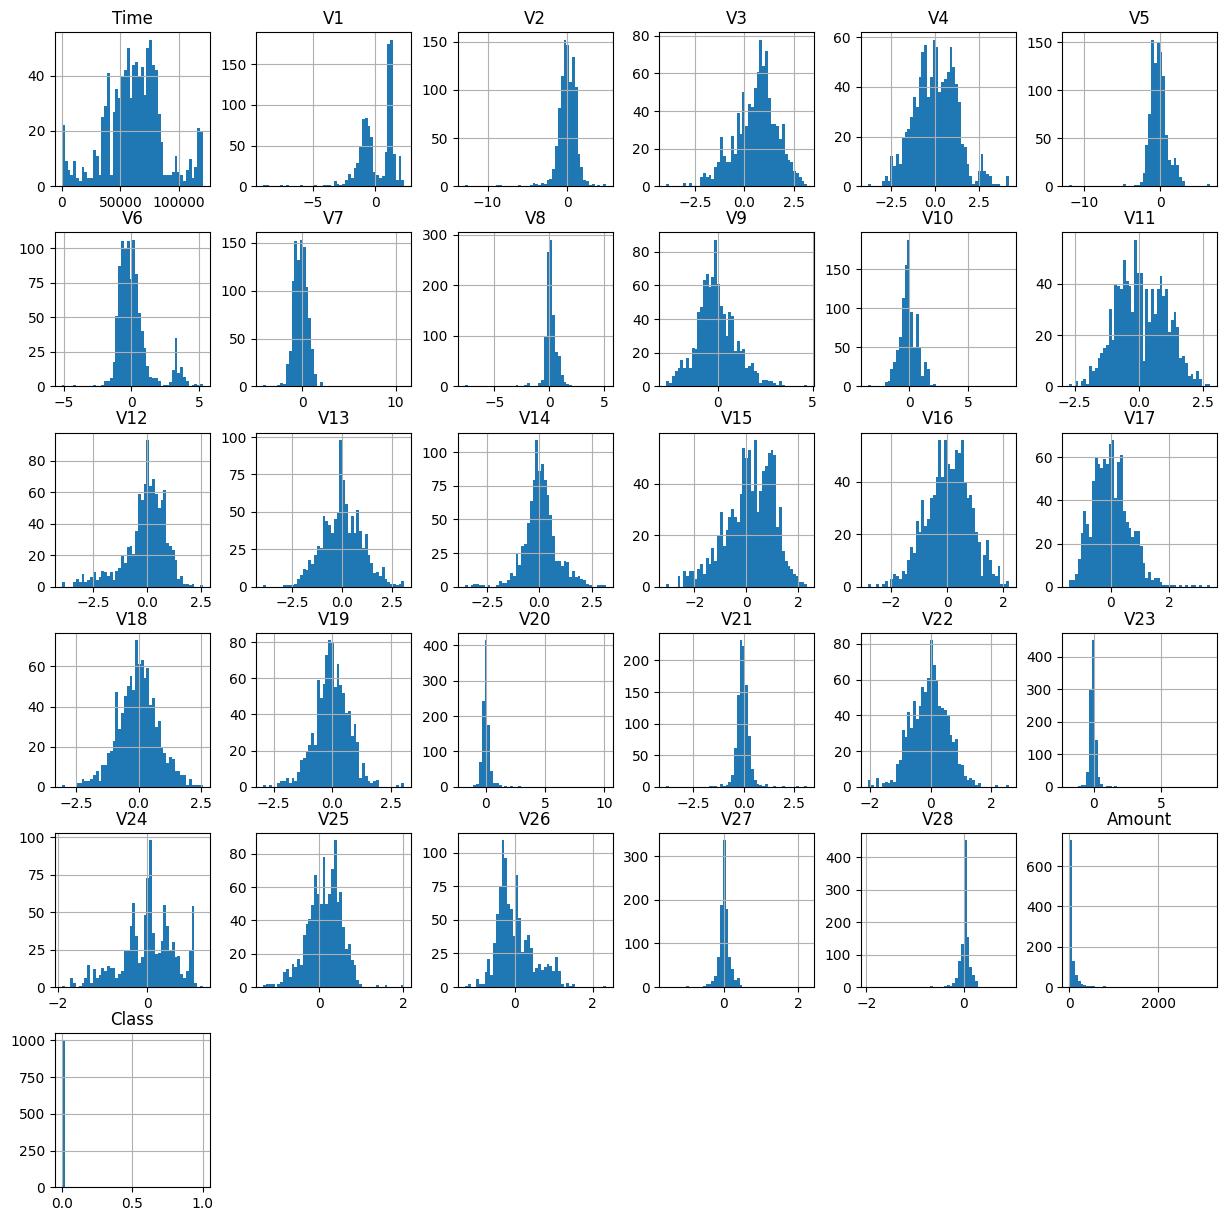

In [24]:
# look at a random subset of data
train_subset = train.sample(1000)
train_subset.hist(bins=50, figsize=(15, 15))
plt.show()

Virtually all columns follow bell curve, meaning fraud cases likely to exist as outliers.

Generate correlation heatmap (TODO: visualise better)

<Axes: >

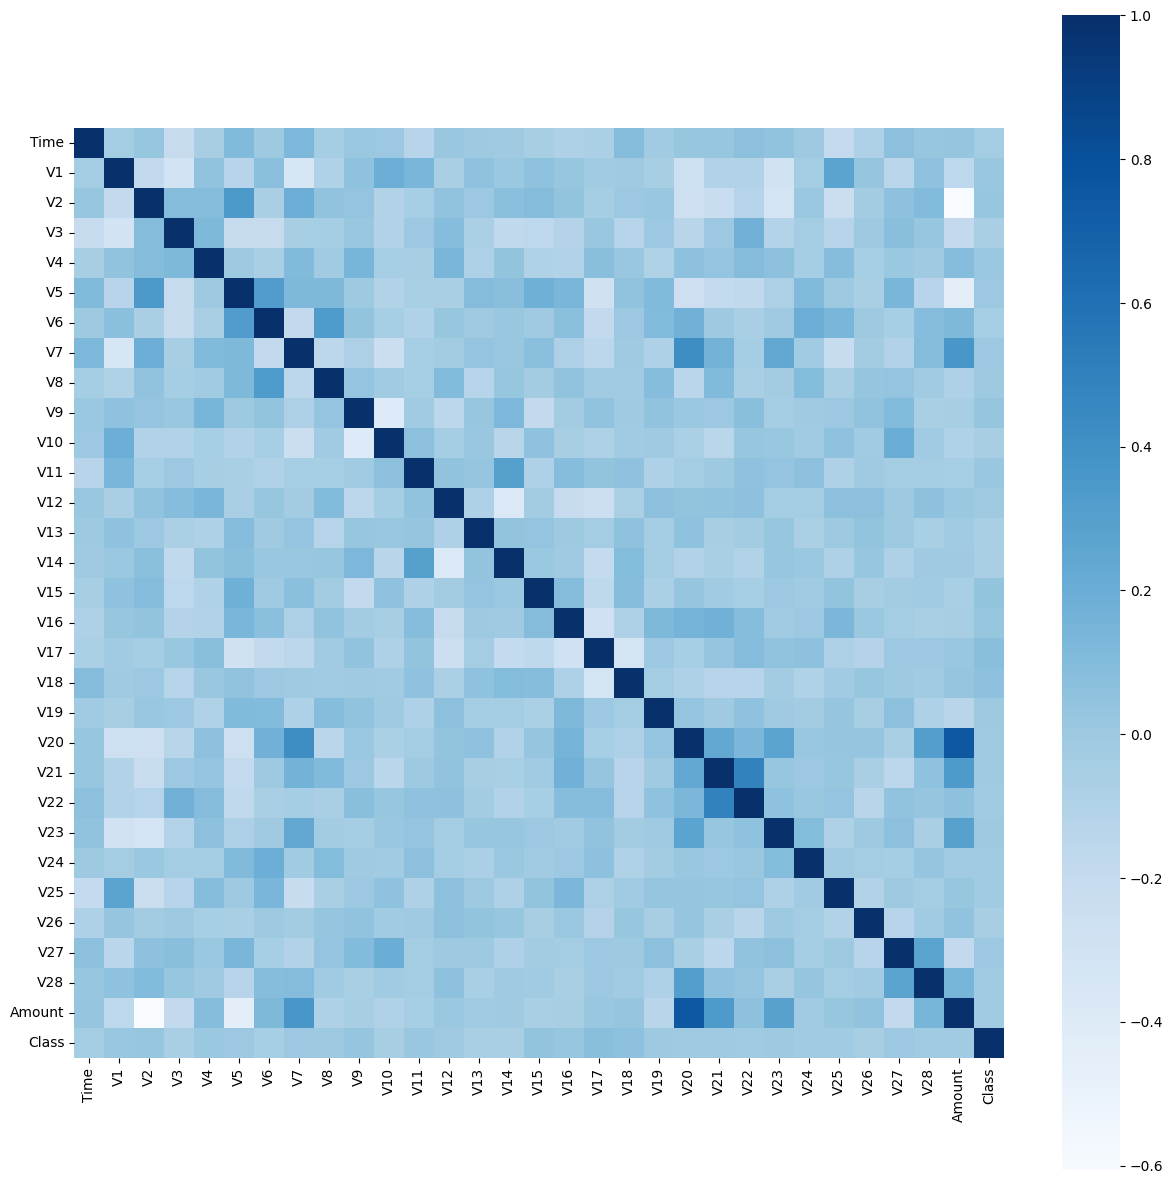

In [25]:
corr = train_subset.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
sb.heatmap(corr, cmap="Blues", ax=ax, square=True)

Focus correlations on `Class`:

In [26]:
cor = train_subset.corr() # correlation coefficients (correlation with price)
pd.DataFrame(abs(cor['Class']).sort_values(ascending=False))

,Class
Class,1.000000
V17,0.081896
V14,0.066586
V3,0.064379
V18,0.061462
V13,0.055129
V26,0.051401
V10,0.050264
V15,0.043509
V6,0.041880


No great correlations present.

---
### 3. Imputing

Since the dataset is already complete we must remove some data first. \
Define method which removes between 10% and 40% of entries in 70% of columns, is seeded.

In [28]:
def remover(df):
  remove_vals = df.copy();
  num_columns = len(remove_vals.columns);
  np.random.seed(SEED)
  rem_columns = round(num_columns * 0.7, 0)
  random_arr = []
  count = 0

  while count < rem_columns :
    r = np.random.randint(1, num_columns - 1);
    if r not in random_arr:
      count += 1;
      random_arr.append(r);

  count = 0;
  for column in remove_vals:
    if count in random_arr:
      random_perc = np.random.uniform(0.1, 0.4);
      cur_mask = np.random.choice([True, False], size= len(remove_vals[column]), p=[random_perc, 1 - random_perc]);
      remove_vals[column] = remove_vals[column].mask(cur_mask);
    count += 1;
      
  return remove_vals

Apply to `X_train`

In [30]:
X_train = remover(X_train)
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,NaN,-0.129425,-1.137418,0.412846,-0.192638,NaN,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,NaN,0.502467,NaN,0.065688,NaN,-0.323800,NaN,-0.292969,NaN,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98
1,0.0,NaN,NaN,-0.520969,-0.894539,NaN,-0.270866,NaN,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,NaN,0.716784,NaN,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00
2,0.0,0.091535,1.004517,NaN,-0.435249,0.667548,-0.988351,NaN,NaN,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,NaN,NaN,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69
3,0.0,NaN,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,NaN,-0.340089,NaN,-0.079792,0.167701,-0.042939,NaN,-0.096148,-0.057780,-0.073839,1.00
4,0.0,1.025898,NaN,1.203717,1.243900,-0.636572,NaN,-0.938651,0.569239,0.692665,NaN,NaN,1.391399,-0.128167,-0.081836,NaN,-0.338937,NaN,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00


Impute methods

In [ ]:
# TODO 


---
### 4. Balancing

In [7]:
# apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='minority')
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# apply random undersampling to balance the class distribution
rus = RandomUnderSampler(sampling_strategy='majority')
X_train_bal, y_train_bal = rus.fit_resample(X_train_bal, y_train_bal)

In [13]:
# lets just check how much of our resampled set is fraudulent
fraud_bal = y_train_bal.sum()
fraud_percent_bal = fraud_bal/len(y_train_bal) * 100

print('new fraud', fraud_bal, '\ntotal entries', len(y_train_bal), '\nnew fraud rate', fraud_percent_bal, '%')

new fraud 218660 
total entries 437320 
new fraud rate 50.0 %


---
### 5. Present models
We trained four distinct models:

#### 5.1. Decision Tree


Using cross validation to find best params for model. 
- `criterion` is being cross validated to find the best splitting method.
- `min_samples_leaf` is being cross validated because it directly changes the probabilities that are predicted.

In [10]:
params = { 
           'criterion':        ['gini', 'entropy', 'log_loss'], 
           'min_samples_leaf': [25, 50, 75, 100] 
         }

clf = GridSearchCV(tree.DecisionTreeClassifier(), params, cv=2)
clf = clf.fit(X_train, y_train)
clf.best_estimator_

DecisionTreeClassifier(min_samples_leaf=25)

Can use CV results to predict fruad probabilities on entries in the test set (and export to csv)

In [12]:
predictions_test = clf.predict_proba(test)

# Create a new DataFrame with 'id' and 'predicted' columns and export to csv.
predictions_test_fraud_prob = predictions_test[:,1]
predictions_test_fraud_prob = pd.DataFrame({'id': test.index, 'Class': predictions_test_fraud_prob})
predictions_test_fraud_prob.to_csv('decision_tree.csv', index = False)

#### 5.2. Logistic Regression

#### 5.3. Random Forest

#### 5.4. Stochasatic Gradient Descent

---
### 6. Evaluation